In [1]:
# @title Setup for Titanic Dataset

'''
loaded the titanic dataset directly from the seaborn git repo to avoid
uploading the CSV into colab for each new run
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load the Titanic dataset
df = sns.load_dataset('titanic')

# Droping columns that make this too complex
df = df.drop(columns=['deck', 'who', 'adult_male', 'alive'])

print("Data Loaded")
print(df.info())
df.head()

Data Loaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   embark_town  889 non-null    object  
 10  alone        891 non-null    bool    
dtypes: bool(1), category(1), float64(2), int64(4), object(3)
memory usage: 64.6+ KB
None


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,True


In [5]:
# @title 1: Handling Missing Values

# 1. Identify missing values
print("Missing Values Before Imputation")
print(df.isnull().sum())

df['age'] = df['age'].fillna(df['age'].median())

mode_embark = df['embark_town'].mode()[0]
df['embark_town'] = df['embark_town'].fillna(mode_embark)

print("\n Missing Values After Imputation")
print(df[['age', 'embark_town']].isnull().sum())

Missing Values Before Imputation
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       2
class          0
embark_town    0
alone          0
dtype: int64

 Missing Values After Imputation
age            0
embark_town    0
dtype: int64


# 1: Handling Missing Values
- Median is preferred for Age to avoid outliers skewing the average.
- Mode is the standard for categorical data since you can't calculate a mean for text.

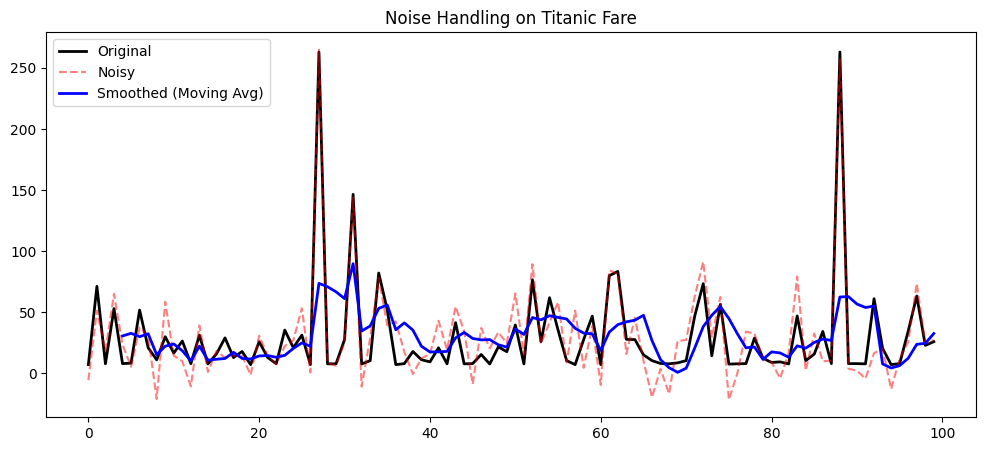

In [6]:
# @title 2: Noise Detection and Handling

# Selected FARE as feature
original_signal = df['fare'].iloc[:100] # Take first 100 rows for clearer plotting

# 1. Adding Artificial Noise
noise = np.random.normal(0, 15, size=len(original_signal)) # Mean=0, Std=15
noisy_signal = original_signal + noise

# 2. Apply Noise Handling
# Window size 5 means we average the current point with the previous 4
smoothed_signal = pd.Series(noisy_signal).rolling(window=5).mean()

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(original_signal, label='Original', color='black', linewidth=2)
plt.plot(noisy_signal, label='Noisy', color='red', alpha=0.5, linestyle='--')
plt.plot(smoothed_signal, label='Smoothed (Moving Avg)', color='blue', linewidth=2)
plt.title('Noise Handling on Titanic Fare')
plt.legend()
plt.show()

Number of outliers detected in Fare: 20


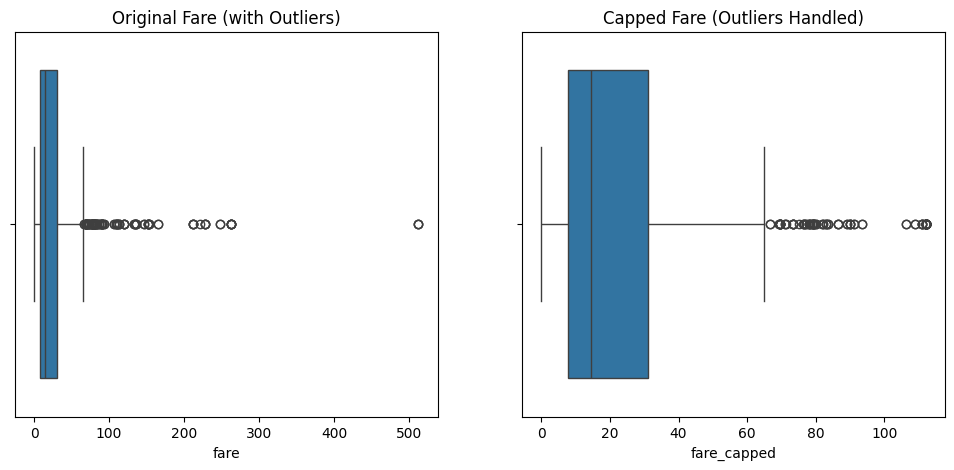

In [7]:
# @title 3: Outlier Detection and Handling

from scipy import stats

# 1. Detect Outliers (Z-score > 3)
z_scores = np.abs(stats.zscore(df['fare']))
outliers = np.where(z_scores > 3)

print(f"Number of outliers detected in Fare: {len(outliers[0])}")

# 2. Handle Outliers: Transformation (Capping/Clipping)
# Instead of deleting rows, we cap values at the 95th percentile
upper_limit = df['fare'].quantile(0.95)
df['fare_capped'] = np.where(df['fare'] > upper_limit, upper_limit, df['fare'])

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['fare'])
plt.title('Original Fare (with Outliers)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['fare_capped'])
plt.title('Capped Fare (Outliers Handled)')
plt.show()



# 3: Outlier Detection and Handling

### **Justification:**
- I chose capping because deleting high-paying passengers might remove valuable information about survival rates.

In [9]:
# @title 4: Data Transformation

# Categorical Encoding (One-Hot Encoding)
# This converts 'sex' into a new column 'sex_male'.
# drop_first=True removes the redundant 'sex_female' column (since if male=0, female must be 1).

df_encoded = pd.get_dummies(df, columns=['sex'], drop_first=True)

# Display the new column alongside the original (though original is now dropped/replaced in df_encoded)
print("After One-Hot Encoding")
print(df_encoded[['age', 'fare', 'sex_male']].head())

--- After One-Hot Encoding ---
    age     fare  sex_male
0  22.0   7.2500      True
1  38.0  71.2833     False
2  26.0   7.9250     False
3  35.0  53.1000     False
4  35.0   8.0500      True


# 4: Data Transformation
### **Explanation:**
The column 'sex' is replaced by 'sex_male'.
- 1 represents 'male'
- 0 represents 'female' <br>
This solves the problem of ML algorithms not being able to do math on text by converting it into 0 or 1.

In [10]:
# @title 5: Feature Scaling

# Select features
features_to_scale = df[['age', 'fare']]

# 1. Standardization (Z-score scaling)
scaler_std = StandardScaler()
scaled_std = scaler_std.fit_transform(features_to_scale)
df_std = pd.DataFrame(scaled_std, columns=['age_std', 'fare_std'])

# 2. Normalization (Min-Max scaling)
scaler_minmax = MinMaxScaler()
scaled_minmax = scaler_minmax.fit_transform(features_to_scale)
df_minmax = pd.DataFrame(scaled_minmax, columns=['age_minmax', 'fare_minmax'])

# Comparison
print("Standardization (Mean ~0, Std ~1)")
print(df_std.describe().loc[['mean', 'std', 'min', 'max']])

print("\nNormalization (Min 0, Max 1)")
print(df_minmax.describe().loc[['mean', 'std', 'min', 'max']])

# Explanation:
# - Use Standardization (Z-score) when algorithms assume a Gaussian distribution (e.g., Logistic Regression).
# - Use Normalization (Min-Max) when you need a fixed range [0, 1] (e.g., Neural Networks, Image Processing).

Standardization (Mean ~0, Std ~1)
           age_std      fare_std
mean  2.272780e-16  3.987333e-18
std   1.000562e+00  1.000562e+00
min  -2.224156e+00 -6.484217e-01
max   3.891554e+00  9.667167e+00

Normalization (Min 0, Max 1)
      age_minmax  fare_minmax
mean    0.363679     0.062858
std     0.163605     0.096995
min     0.000000     0.000000
max     1.000000     1.000000


# 5: Feature Scaling
### **Explanation:**
- Use Standardization (Z-score) when algorithms assume a Gaussian distribution (e.g., Logistic Regression).
- Use Normalization (Min-Max) when a fixed range is needed [0, 1] (e.g., Neural Networks, Image Processing).

In [14]:
# @title Raw Dataset and Processed Dataset comparision

# Reloading the original data into 'df_raw'

df_raw = sns.load_dataset('titanic')

# comparison

print("             RAW DATA SUMMARY            ")
print(f"Missing Values in Age: {df_raw['age'].isnull().sum()}")
print(f"Shape: {df_raw.shape}")
print("Note: 'sex' is text, 'age' has NaNs:")
display(df_raw[['age', 'sex', 'fare']].head(20))

print("\n\n")


print("          PROCESSED DATA SUMMARY         ")
print(f"Missing Values in Age: {df['age'].isnull().sum()}")
print(f"Shape: {df.shape}")
print("Note: 'sex_male' is numeric, 'age' is filled:")

display(df_encoded[['age', 'sex_male', 'fare']].head(20))

             RAW DATA SUMMARY            
Missing Values in Age: 177
Shape: (891, 15)
Note: 'sex' is text, 'age' has NaNs:


,age,sex,fare
0,22.0,male,7.2500
1,38.0,female,71.2833
2,26.0,female,7.9250
3,35.0,female,53.1000
4,35.0,male,8.0500
5,NaN,male,8.4583
6,54.0,male,51.8625
7,2.0,male,21.0750
8,27.0,female,11.1333
9,14.0,female,30.0708





          PROCESSED DATA SUMMARY         
Missing Values in Age: 0
Shape: (891, 12)
Note: 'sex_male' is numeric, 'age' is filled:


,age,sex_male,fare
0,22.0,True,7.2500
1,38.0,False,71.2833
2,26.0,False,7.9250
3,35.0,False,53.1000
4,35.0,True,8.0500
5,28.0,True,8.4583
6,54.0,True,51.8625
7,2.0,True,21.0750
8,27.0,False,11.1333
9,14.0,False,30.0708
